## MH2 Unsupervised clustering

Trying to replicate results of unsupervised clustering for Supernova Hunters with the MuonHunters2 data.

In [1]:
%matplotlib inline
import os
import pickle
from dec_keras import DEC
import matplotlib.pyplot as plt
import numpy as np
import pandas
from collections import OrderedDict

from keras.optimizers import SGD

from muon.dissolving.utils import get_cluster_centres
from muon.dissolving.utils import pca_plot

from muon.dissolving.redec import ReDEC
from muon.deep_clustering.clustering import Config

from muon.deep_clustering.clustering import discrete_cmap

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)



lcolours = ['#CAA8F5', '#D6FF79', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#B0FF92', '#D9F0FF', '#46351D']


def load_dec(ae_weights, dec_weights, x, n_clusters, dims):
    dec = DEC(dims, n_clusters=n_clusters)
    dec.initialize_model(optimizer=None, ae_weights=ae_weights, x=x)
    dec.model.load_weights(dec_weights, by_name=True)
    
    return dec

def plot_dec(dec, x_train, y_train, n_clusters):
    cluster_centres = get_cluster_centres(dec)
    labels = [str(i) for i in range(n_clusters)]
    pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])
    
def load_redec(save_dir, x_train):
    ae_weights = os.path.join(save_dir, 'ae_weights.h5')
    dec_weights = os.path.join(save_dir, 'DEC_model_final.h5')
    config = Config.load('mnt/clustering_models/dec/dec_no_labels/config.json')
    
    redec = ReDEC(
        metrics=None,
        dims=[x_train.shape[1]]+config.nodes,
        n_clusters=50,
        n_classes=2)

    redec.initialize_model(
        optimizer=SGD(lr=.01, momentum=.9),
        ae_weights=ae_weights,
        x=x_train)
    
    redec.model.load_weights(dec_weights)
    
    return redec

def report_run(fname, title):
    metrics = pickle.load(open(fname, 'rb'))
    if type(metrics) is dict:
        metrics = metrics['metrics']
    if 'redec_mark' not in metrics.__dict__:
        metrics.redec_mark = None
    fig = plt.figure(figsize=(15,8))
    metrics.plot(fig, title=title)
    
    return metrics.dump()
    
def report_runs(fnames_titles):
    data = []
    for fname, title in fnames_titles:
        row = OrderedDict([('title', title)])
        item = report_run(fname, title)
        row.update([(k, item[k][-1]) for k in sorted(item)])
        row['iteration'] += 1
        data.append(row)
        plt.show()
        
    display(pandas.DataFrame(data))



Using TensorFlow backend.


Below are training metrics of various training runs of the multitask step. The gamma parameter describes how much weight is given to the reconstruction loss. When gamma=1, the reconstruction loss is given the same weight as the classifier loss.

All runs so far are using Hugh's labels. Assuming gold standard quality.

Results of the last iteration are summarized in the table below

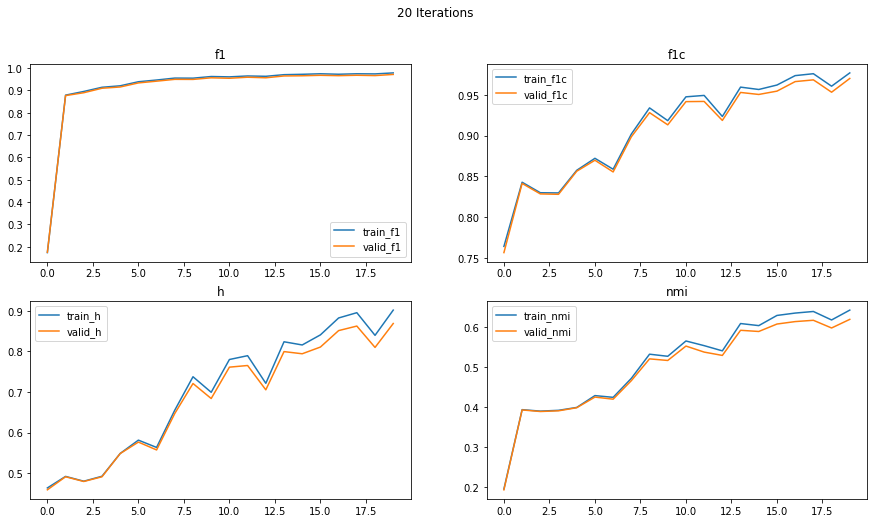

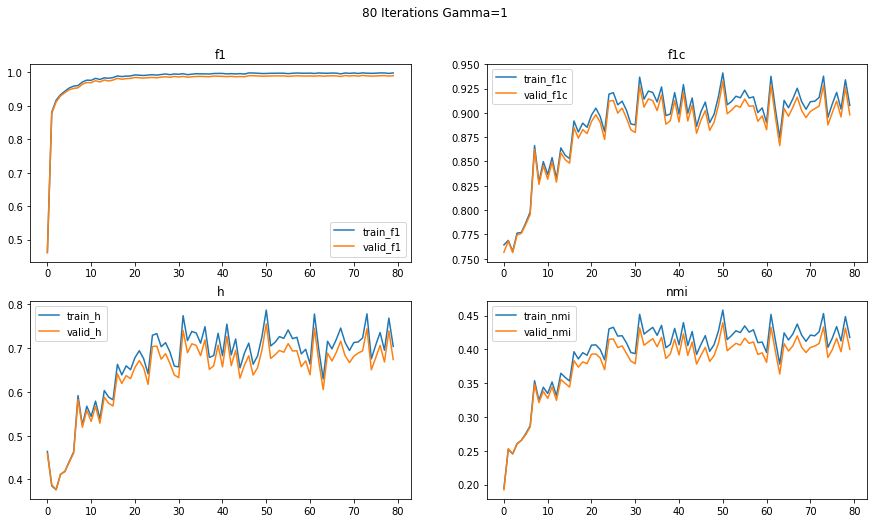

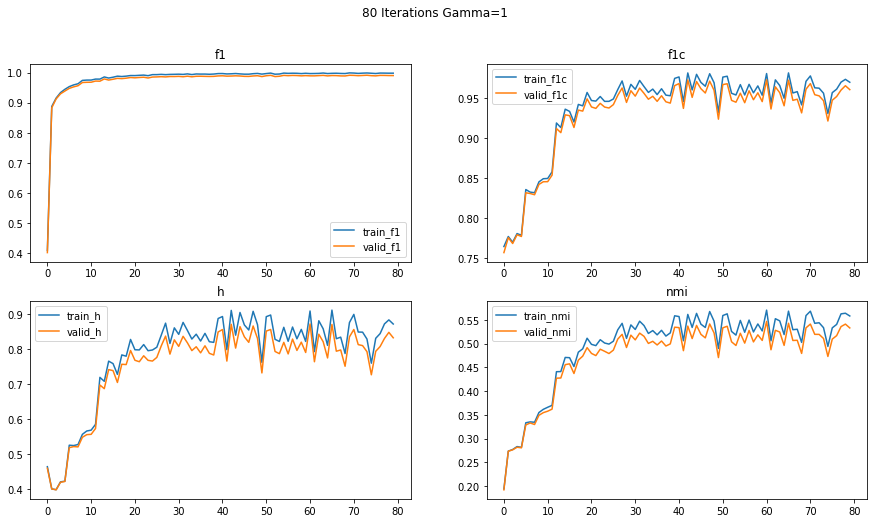

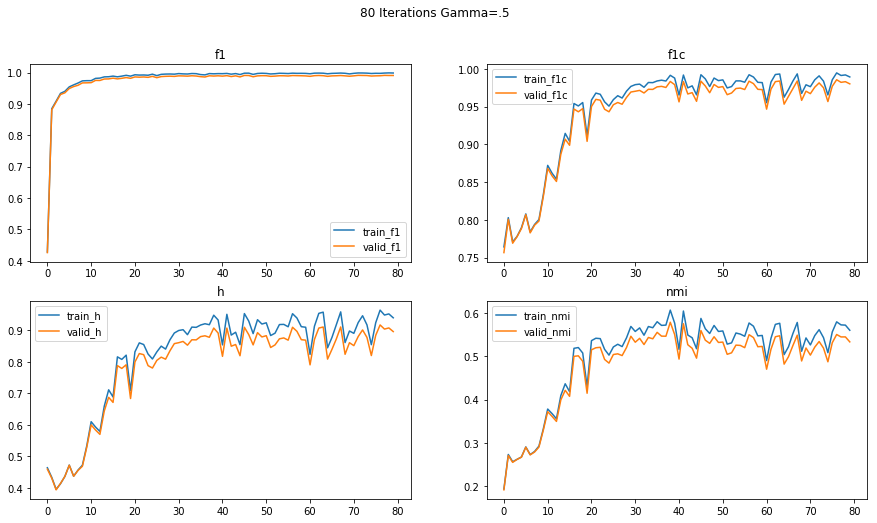

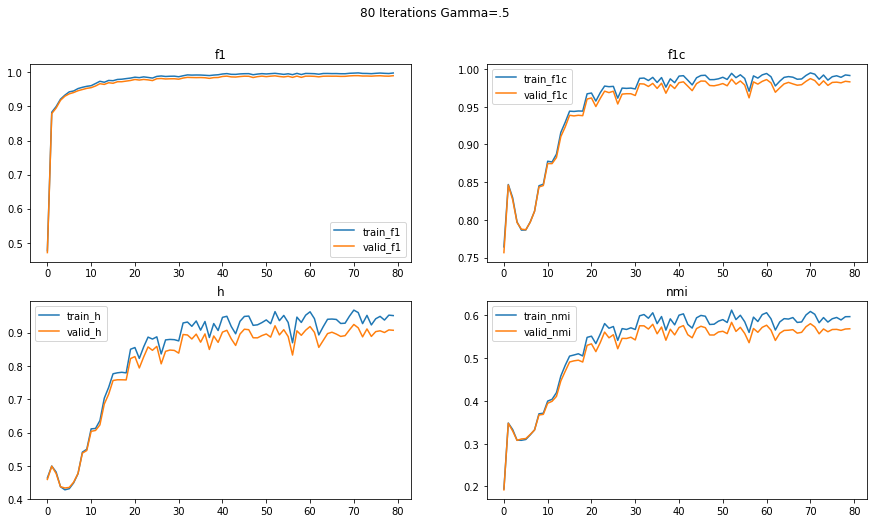

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,20 Iterations,20,0.978395,0.976840,0.901262,0.643121,0.971553,0.970043,0.868307,0.619892
1,80 Iterations Gamma=1,80,0.998163,0.907641,0.703590,0.417669,0.989910,0.898007,0.673644,0.400105
2,80 Iterations Gamma=1,80,0.997810,0.970219,0.871511,0.558021,0.989871,0.960969,0.832188,0.532859
3,80 Iterations Gamma=.5,80,0.998539,0.989160,0.940344,0.559435,0.990679,0.980005,0.896537,0.532711
4,80 Iterations Gamma=.5,80,0.998315,0.991486,0.950881,0.596920,0.990339,0.983078,0.906821,0.568545


In [2]:
report_runs([
#     ('mnt/clustering_models/run_multitask_1/results_final.pkl', '10 Iterations'),
#     ('mnt/clustering_models/run_multitask_2/results_final.pkl', '10 Iterations 2'),
    ('mnt/clustering_models/run_multitask_2_2/results_final.pkl', '20 Iterations'),
#     ('mnt/clustering_models/run_multitask_3/results_final.pkl', '20 Iterations Gamma=1'),
    ('mnt/clustering_models/run_multitask_4_1/results_final.pkl', '80 Iterations Gamma=1'),
#     ('mnt/clustering_models/run_multitask_5_1/results_final.pkl', '80 Iterations Gamma=.5'),
    ('mnt/clustering_models/run_multitask_4/metrics_intermediate.pkl', '80 Iterations Gamma=1'),
    ('mnt/clustering_models/run_multitask_5/metrics_intermediate.pkl', '80 Iterations Gamma=.5'),
    ('mnt/clustering_models/run_multitask_6/metrics_intermediate.pkl', '80 Iterations Gamma=.5')
#     ('mnt/clustering_models/run_multitask_7/metrics_intermediate.pkl', '80 Iterations Gamma=.5')
])

Took the second model from above and ran the reclustering step on it. The model tries to move the clusters around given the new embedding learned in the multitask step. The figure below shows the training metrics of both the multitask step and the reclustering step. The green dotted line shows when the reclustering step was started.

None


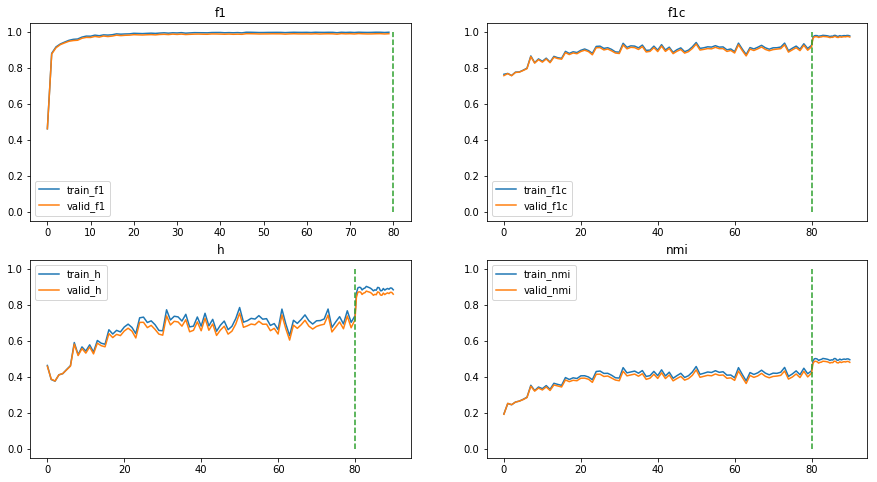

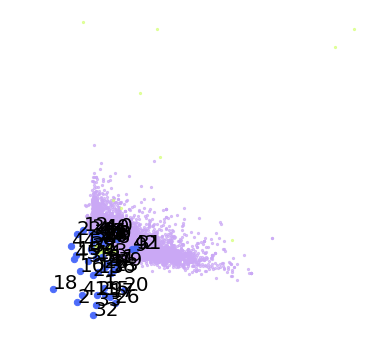

In [3]:
with open('mnt/subjects/tt_split_hugh_xy.pkl', 'rb') as f:
    splits = pickle.load(f)
    
x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

n_classes = 2
n_clusters = 50
save_dir = 'mnt/clustering_models/run_multitask_4_1/run_redec_1'

redec = load_redec(os.path.join(save_dir), x_train)
with open(os.path.join(save_dir, 'metrics_intermediate.pkl'), 'rb') as f:
    metrics = pickle.load(f)
for i in range(len(metrics.metrics)):
    if metrics.metrics[i]['iteration'] == metrics.redec_mark:
        break

batches = np.ceil((x_train.shape[0]+x_train_dev.shape[0]) / 256).astype(np.int)
# print(i, batches, metrics.redec_mark, metrics.metrics[i])
# print(metrics.metrics[80-1])
for i in range(i, len(metrics.metrics)):
    metrics.metrics[i]['iteration'] = (metrics.metrics[i]['iteration']-80)/batches+80
    
print(metrics.print_ite(metrics.last_ite()))
fig = plt.figure(figsize=(15,8))
metrics.plot(fig, )

plot_dec(redec, x_train, y_train, n_clusters)

Figure below shows the final cluster segmentation

[ 0  3  4  6  9 14 16 24 25 31 34 46 47 48]


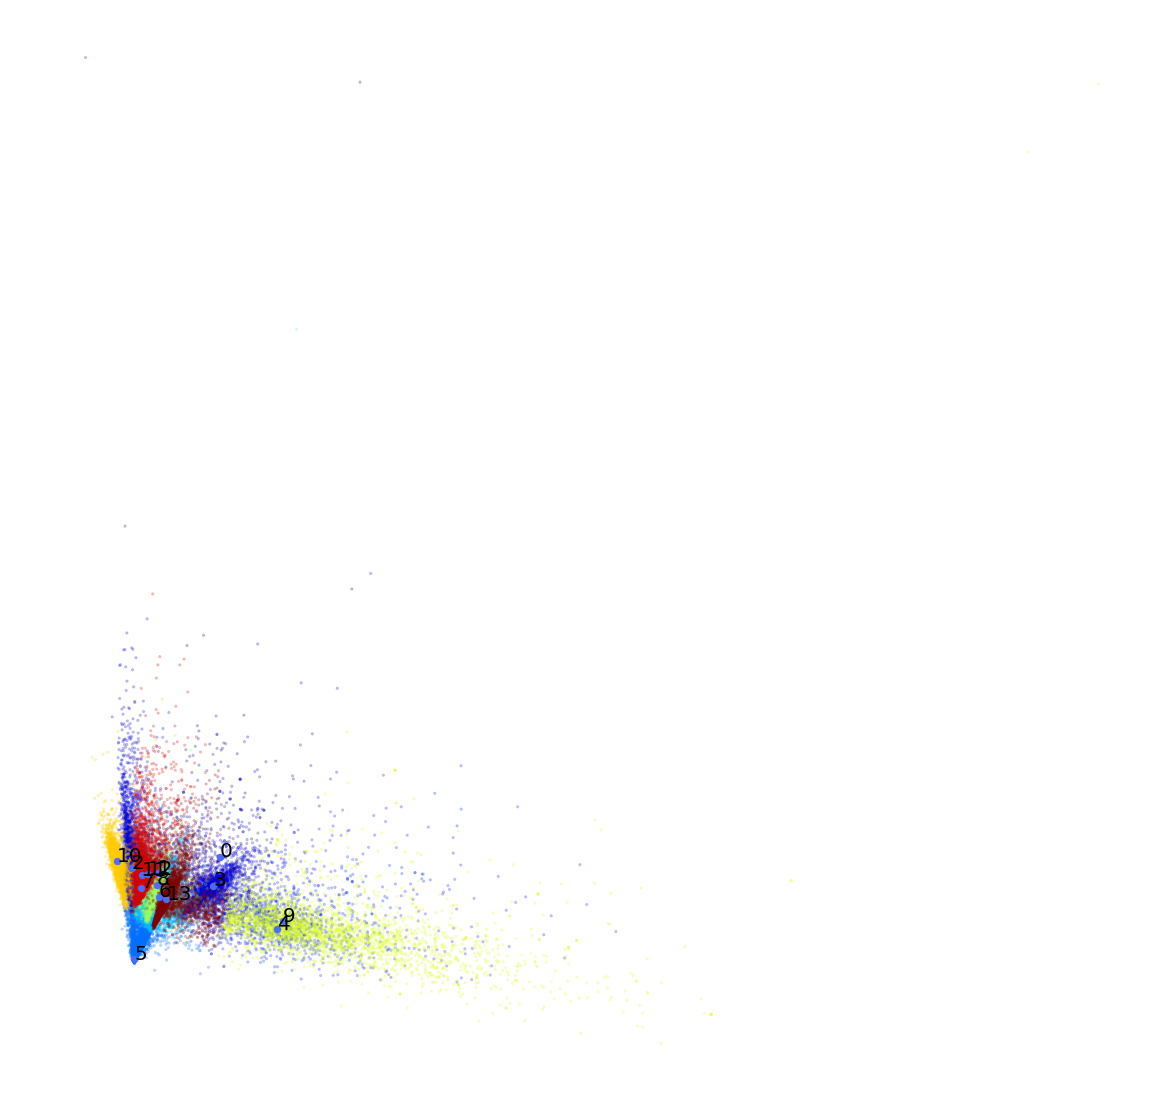

In [4]:
from sklearn.decomposition import PCA
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap


def pca_plotv2(dec, x, n_clusters):
    y = dec.predict_clusters(x)
    cluster_centers = dec.model.get_layer(name='clustering')
    cluster_centers = cluster_centers.get_weights()
    cluster_centers = np.squeeze(np.array(cluster_centers))

    labels = [str(i) for i in range(n_clusters)]
    
    unique = np.unique(y)
    cluster_ids = unique
    cluster_centers = cluster_centers[unique,:]
    labels = np.array(labels)[unique]
    
    print(unique)
    _pca_plot(dec, x, cluster_centers, cluster_ids, y, labels=labels)
    
def _pca_plot(dec, x, cluster_centres, cluster_ids, y=None, labels=[],
              ulcolour='#747777', ccolour='#4D6CFA'):
    base_network = dec.encoder

    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(base_network.predict(x))
    c_pca = pca.transform(cluster_centres)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    if np.any(y):
        unique_targets = list(np.unique(y))
        cmap = discrete_cmap(len(unique_targets), 'jet')
        norm = matplotlib.colors.BoundaryNorm(
            np.arange(0, max(unique_targets), 1), cmap.N)

        if -1 in unique_targets:
            _x = x_pca[np.where(y == -1), 0]
            _y = x_pca[np.where(y == -1), 1]
            ax.scatter(_x, _y, marker='o', s=20, c=ulcolour, alpha=0.1)
            unique_targets.remove(-1)
        for l in unique_targets:
            _x = x_pca[np.where(y == l), 0]
            _y = x_pca[np.where(y == l), 1]
            _c = l * np.ones(_x.shape)
            ax.scatter(_x, _y, marker='o', s=5, c=_c,
                       cmap=cmap, norm=norm, alpha=0.2, label=labels[np.where(cluster_ids==l)])

    else:
        ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, \
            color=ulcolour, alpha=0.1)
        
    ax.scatter(
        c_pca[:,0], c_pca[:,1],
        marker='o', s=40, color=ccolour, alpha=1.0, label='cluster centre')

    for i in range(len(cluster_centres)):
        ax.text(c_pca[i,0], c_pca[i,1], str(i), size=20)

    plt.axis('off')

pca_plotv2(redec, x_train, 50)
plt.show()

In [5]:
cmap = list(zip(*redec.get_cluster_map(x_train, y_train)))
cmap = pandas.DataFrame(cmap, columns=['majority class', 'n_assigned', 'purity'])
display(cmap.loc[cmap['n_assigned']>0])

/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
0,0,31,0.903226
3,0,1327,1.000000
4,0,6060,0.998350
6,0,3375,0.998815
9,0,1155,0.999134
14,1,20359,0.968613
16,0,4648,0.985585
24,1,1,1.000000
25,0,3912,0.992843
31,0,2976,0.998992
